In [1]:
from torchvision import utils
from basic_fcn import *
from dataloader import *
from utils import *
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt


torch.Size([1, 3, 512, 1024])
Ground truth
Predicted
(1, 512, 1024)
[5.60723869e-01 6.46039446e-02 3.72851765e-01 2.21033493e-02
 2.43089237e-02 5.15501485e-03 3.91923016e-03 1.50590422e-05
 2.72644220e-01 2.31254325e-03 7.44336438e-01 1.32417597e-03
 0.00000000e+00 2.42148880e-01 0.00000000e+00 9.23938181e-04
 0.00000000e+00 0.00000000e+00 3.41148593e-06]
(19,)
Epoch 100: Pixel Acc: 0.5977123975753784, IOU Acc: 0.12196709274762887
building0.37285176499589306, traffic sign1.5059042201890124e-05, person0.0013241759698031429, car0.24214887992933093, bicycle3.411485927279401e-06
(tensor(0.5977), 0.12196709274762887)


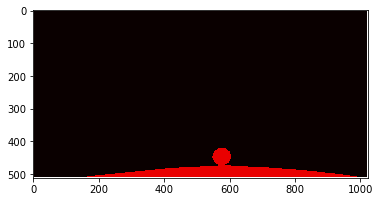

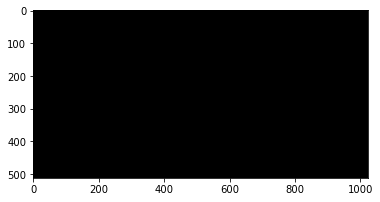

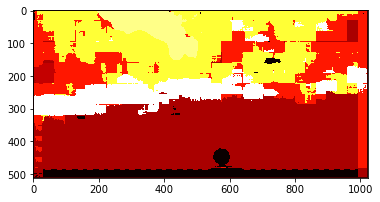

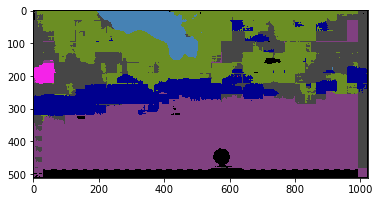

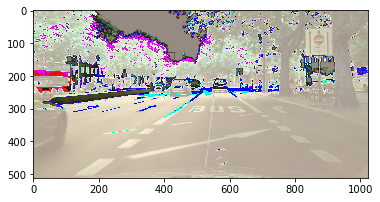

In [4]:
transforms_composed = transforms.Compose([
                        transforms.Resize((512,1024)),
#                         transforms.RandomRotation(degrees=30),
#                         transforms.RandomHorizontalFlip(p=1),
])
test_dataset = CityScapesDataset(csv_file='test.csv',transforms = transforms_composed)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=1,
                          num_workers=1,
                          shuffle=False)
val_dataset = CityScapesDataset(csv_file='val.csv', transforms = transforms_composed)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=2,
                          num_workers=6,
                          shuffle=True)

use_gpu = torch.cuda.is_available()
model = torch.load('best_model1')

def val(epoch,flag = True):
    # Complete this function - Calculate loss, accuracy and IoU for every epoch
    # Make sure to include a softmax after the output from your model
    p_acc = 0
    iou_acc = 0
    iou_int = []
    iou_union = []
    count = 0
    model.eval()
    losses = []
    for iter, (X, tar, Y) in enumerate(val_loader):
        if use_gpu:
            X = X.cuda()
            tar = tar.cuda()
            Y = Y.cuda()
        else:
            X,tar,Y = X.cpu(), tar.cpu(),Y.cpu()
            
        if flag:
            with torch.no_grad():
                outputs = model(X)
            losses.append(criterion(outputs, Y).item())
            continue
        p, iou_i, iou_u = model.evaluate(X, tar,Y)
        p_acc += p
#         iou = np.array(iou)
        iou_int.append(iou_i)
        iou_union.append(iou_u) 
#         mask = np.logical_not(np.isnan(iou))
#         iou_acc += np.mean(iou[mask])
        count += 1
    if flag:
        return np.mean(np.array(losses))
    iou_int = np.sum(np.array(iou_int),axis=0)
    iou_union = np.sum(np.array(iou_union),axis=0)
    iou_acc = iou_int/iou_union
    print(iou_acc)
    print(iou_acc.shape)
    print("Epoch {}: Pixel Acc: {}, IOU Acc: {}".format(epoch, p_acc/count, np.mean(iou_acc)))
    print("building{}, traffic sign{}, person{}, car{}, bicycle{}".format(
        iou_acc[2],iou_acc[7],iou_acc[11],iou_acc[13],iou_acc[18]))
    return p_acc/count, np.mean(iou_acc)

for iter, (X, tar, Y) in enumerate(test_loader):
    print(X.shape)
    Y = Y.cpu().data.numpy()
    print("Ground truth")
    plt.imshow(Y[0], cmap='hot', interpolation='nearest')
    plt.figure()
    img = np.zeros((Y.shape[1],Y.shape[2],3))
    for ind in range(n_class):
        arg = np.argwhere(Y[0]==ind)
        img[arg[:,0],arg[:,1],0] = labels_classes[ind].color[0]
        img[arg[:,0],arg[:,1],1] = labels_classes[ind].color[1]
        img[arg[:,0],arg[:,1],2] = labels_classes[ind].color[2]
    plt.imshow(img.astype(np.uint8))
    plt.figure()
    print("Predicted")
    pred = model(X.cuda())
    Y = pred.argmax(dim = 1)
    Y = Y.cpu().data.numpy()
    plt.imshow(Y[0], cmap='hot', interpolation='nearest')
    plt.figure()
    print(Y.shape)
    img = np.zeros((Y.shape[1],Y.shape[2],3))
    for ind in range(n_class):
        arg = np.argwhere(Y[0]==ind)
        img[arg[:,0],arg[:,1],0] = labels_classes[ind].color[0]
        img[arg[:,0],arg[:,1],1] = labels_classes[ind].color[1]
        img[arg[:,0],arg[:,1],2] = labels_classes[ind].color[2]
    plt.imshow(img.astype(np.uint8))
    plt.imsave('baseline.png',img.astype(np.uint8))
    plt.figure()
    to_pil = torchvision.transforms.ToPILImage()
    img = to_pil(X[0])
    plt.imshow(img)
    print(val(100,False))
    break
#     if use_gpu:
#         X = X.cuda()
#     else:
#         X,tar= X.cpu()
    
    